# Real or Not? NLP with Disaster Tweets
## Daniel Díez Mallo
### https://www.linkedin.com/in/danieldiezmallo/

This notebook contains the code used to solve the Kaggle challenge "Real or Not? NLP with Disaster Tweets", avialable in https://www.kaggle.com/c/nlp-getting-started. In it, a set of tweets that refer to different disasters is provided, being some of them real and some fake. The objectives is, using supervised learning and NLP, to correctly classify new tweets in real or fake, based on the text of the tweet, location or keywords.

## 1. Import and observe dataset

In [33]:
# Load libraires for data wrangling
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


# Set seed for reproducibility
np.random.seed(5)

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print("Number of tweets in train %s " % (len(train)))
print("Number of tweets in test %s " % (len(test)))

# Visualize head and a summary of numerical values of train data
print("------------train data head------------")
print(train.head(5))
print("------------train data summary------------")
print(train.describe())
print("------------train data missing counts------------")
print("Tweets missing location:", np.sum(train['location'].isna()))
print("Tweets missing keywords:", np.sum(train['keyword'].isna()))
print("Tweets missing text:", np.sum(train['text'].isna()))

Number of tweets in train 7613 
Number of tweets in test 3263 
------------train data head------------
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
------------train data summary------------
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
------------train data missing 

The data consists of a text, that corresponds to the data, and a label that indicates whether the tweet is referring to a real disaster or not. It also contains the location of the tweet if it is available, and the keyword that the tweet may have if available.

It is possible to see as well that, out 7613 tweets in the training, 61 of them are missing the keyword, and 2533 are missing the location, and none of them are missing the text. This is the reason why the main source where features for model training will be extracted is the text of the tweet.

It is also interesting to see that in the training data there are more observation of tweets about fake disasters than real disasters, as it can be seen in the countplot bellow, so the modeling might have to take this into account to avoid skeweness.

Text(0.5, 1.0, 'Count of labels in train data')

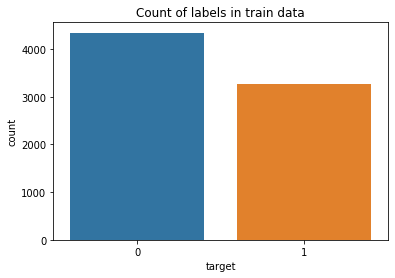

In [34]:
ax = sns.countplot(
                    x='target', 
                    data=train)
ax.set_title('Count of labels in train data')

Now, a statistical analysis of other possible variables is performed. For this, an odds ratio is calculated, from the target and the prportion of tweets for which the locatin is missing. The objective is to determine if fake disaster tweets have a higher probability to not have a location than real disaster ones.

The results show that the odds ratio for this is not in favor of any of the cases, i.e., there is not a significant higher or lower probability of the tweet being real if the location is missing than if it is not.

In [35]:
import scipy.stats as stats

# Calculate a crosstable with the groups by target and missing location flag
table = pd.crosstab(train['target'], 
                            train['location'].isna(),  
                            margins = False
)
print(table)

# Calculate and print oddstario for this table
oddsratio, pvalue = stats.fisher_exact(table)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

location  False  True 
target                
0          2884   1458
1          2196   1075
OddsR:  0.9683087594104257 p-Value: 0.52299711249183


The same approach is performed with the missing keywords. The result here is much more interesting, showing that a tweet that is missing it's keyword is 2.95 time more likely to be a real disaster tweet. However, as the  number of tweets that are missing the keyword is very low in both cases, no conclussions can be inferred from this.

In [36]:
table = pd.crosstab(train['target'], 
                    train['keyword'].isna(),  
                    margins = False
)
print(table)
oddsratio, pvalue = stats.fisher_exact(table)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

keyword  False  True 
target               
0         4323     19
1         3229     42
OddsR:  2.9594627634431387 p-Value: 6.917009114930886e-05


## 2.Text cleaning, tokenization and lemmatization

It is necesary in order to be able to statisticly model the text of the tweets to tokenize the words contained in the text, and convert them into numerical features that can be understood by a computer.

In order to do so, a function is going to be defined, that takes all the text contained in the tweets, tokenizes it and reduces every single one of the words into the stem, so all words and their derivations are counted as the same word.

It is also necesary to look for mentions, hashtags and links that can be contained in the tweets, as these tokens need a different proccesing and need to be identified first.

In [37]:
import re
from nltk.stem.snowball import SnowballStemmer
# Initialize stemmer object
stemmer = SnowballStemmer("english")
# Define a function to perform both stemming and tokenization
def remove_noise_and_tokenize(text):
    """Function that performs text cleanse and tokenization
    
    Arguments:
    ----------
    text: a piece of text
    
    returns: cleaned and tokenized text
    """
    # Lowercase all data
    text = text.lower()
    # Unwanted characters are removed
    text = re.sub(r'http[s]{0,1}?://(\S+)\.', '', text) # Remove links but leave the http identifier and the domains
    text = re.sub(r'www\.(\S+)\.', '', text) # Remove links but leave the http identifier and the domains
    text = re.sub(r'[@#](\S+)', r'\1', text) # get mentions and hashtags names and their identifier
    text = re.sub(r'\[.*?\]', '', text) # remove text in square brackets
    text = re.sub(r'<.*?>+', '', text) # remove everything between <>>>
    text = re.sub(r'\n', '', text) # remove line breaks
    text = re.sub(r'(\w*)\d(\w*)', r'\1\2', text) # remove digits
    text = re.sub(r'[^a-z\s]', '', text) # remove anything that is not a letter or a space
    
    # Tokenize by sentence, then by word
    tokens = [word for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)]
    # Filter out raw tokens to remove noise

    # Stem the filtered_tokens
    tokens = [stemmer.stem(word) for word in tokens]
    # print(text)

    return tokens

This function will then be used to create a Tfidf vector that gives all of the identified tokens a score based on how many times they appear in the tweet they are in, and among the tweets, so very common words are not taken into account as much as words that are unique to some tweets or less uncommon than the rest.

## 3. Create a TfidfVectorizer

In this section, both the training and test text datasets are going to be converted into a set of word vectors. The objective of this step is to create a statistical quantification of the meaning of the words contained in all of the tweets. This way, it is possible to create a set of features that can then be fed to a supervised learning algorithm to create a model.

One approach to this problem, is to simply count the number of words that appear, and use this count vectorizer as the imput. However, it was decided to use a "term frecuency inverse document frecuency" vector, of TFID vector. It gives each word a score based on how many times it appears in a document or tweet, but it also pensalizes the words that appear in a lot of documents. This way, the most relevant words would be those that appear a lot in a tweet, but do not appear in many of them.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Create a vectorizer object
max_features = None
min_frequency = 2/len(train) # Minimum frequency of a word among texts
tfidf_vectorizer = TfidfVectorizer(
                                    max_features=max_features, # max features to evaluate
                                    max_df=0.8, # drops words that appear in this proportion of the documents (topic stopwprds)
                                    min_df=min_frequency, # drops words that appear in a single tweet
                                    ngram_range=(1,1), # combinations of words of only one word
                                    stop_words='english', # language of stopwords to be removed from the text
                                    use_idf=True, # enable inverse frecuency to find frequency among documents
                                    tokenizer=remove_noise_and_tokenize # function to tokenize the words in a document (previously defined)
)

In [39]:
# Before creating the vectorizer, the keywords are added to the text, at the beginning
# train['text'] = train['keyword'].astype(str) + ' ' + train['text'].astype(str)

# Fit the TFIDF vector with the text in the training data and transform it
x_train_tfidf = tfidf_vectorizer.fit_transform(train['text'])

# Transform the test data into another vecor for the predictions
x_test_tfidf = tfidf_vectorizer.transform(test['text'])

print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(7613, 5112)
(3263, 5112)


Now that the vectorizer has been created and a tfidf score has been given to each word, it is possible to examine them, by creating a Pandas DataFrame. It is possible to see that the least scored tokens are the ones corresponding to links, mentions and hashtags, as these appear in many of the documents.

In [40]:
word_features = tfidf_vectorizer.get_feature_names()
features = pd.DataFrame(
                        zip(word_features, tfidf_vectorizer.idf_), 
                        columns=['word', 'tfidf']
                        )
features = features.sort_values(by=['tfidf'], ascending=False)
print(features)

word     tfidf
5111         zss  8.839132
3163         ohh  8.839132
3143     obvious  8.839132
3149         oct  8.839132
1277  difficulti  8.839132
...          ...       ...
498         bomb  4.521644
139          amp  4.335625
2230          im  4.313726
2435        just  4.201172
2605        like  3.971597

[5112 rows x 2 columns]


## 4. Create train and test data and labels

In this section, data is divided into target and labels. First the labels are extarcted and saved in a different array so they can be fed to the cross validation algorithms.

In [41]:
# Take labels on one side
y_train = train['target']

Then, a new dataframe of features extracted from the text is created, such as the ammount of mentions, hashtags and links in the text, and all the features that could not be extracted by the vectorizer. These features will then be fed to a different machine learning algorithm than the word vecotr, and their result will be combined by the use of a stacking algorithm.

These features are also normalized to avoid bias.

In [61]:
# Create a numpy array that counts number of mentions, hashtags and links in a tweet
feature_names = ['mentions', 'hashtags', 'links', 'n_words', 'avg_len_words']

# Train and test text is joined together so the normalization is consistent in both dataframes
all_text = train['text'].append(test['text'])

from statistics import mean
# Perform the counts
counts = np.transpose(np.array([
                all_text.str.count('@'),
                all_text.str.count('#'),
                all_text.str.count('http') + all_text.str.count('www.'),
                [len(tweet.split()) for tweet in all_text],
                [mean([len(word) for word in tweet.split()]) for tweet in all_text]
]))

print(counts.head())
# This array is then normalized
from sklearn.preprocessing import Normalizer
counts = Normalizer().fit_transform(counts)

# Divide the counts into train and test
x_train_counts = counts[:train.shape[0],:]
x_test_counts = counts[-test.shape[0]:,:]
print(x_train_counts.shape)
print(x_test_counts.shape)

(7613, 5)
(3263, 5)


## 5. Model training and selection

In this section a supervised learning will be trained, using different parameter combinations. Its performance will then be evaluated by cross validation in 5 folds. As there are no target labels available for the test data, it is not possible to establish what the performance of the algorithm is when it is used with new test data. For each best model, the best average cross validation score will be printed. For this purpose, a grid search among serveral parameter combinations will be performed.

For this step two different dataframes have been created:

* A sparse matrix that contains the word features obtained by the cleanse, tokenization and stemming of the text applied into a TFID vectorizer. This data will be used to train a Naive Bayes model, as the ammount of features that need to be proccesed is very hihg, and this algorithm has a very good performance when high dimensionality is involved.
* A dense matrix that contains the counts and other features that were not proccessed by the vectorizer. This data will be used to train a gradient boosting algorithm.

Then, the results of the two previous steps will be combined into a gradient boosting algorithm to using a stacking method, trying to increase the performance of the two previous models.

In order to train and select the best algorithm for each step, a function that finds the best possible model for each algorithm by searching over different combinations of parameters is created.

In [43]:
from sklearn.model_selection import GridSearchCV

def fit_model_GridSearchCV(model, X_, y_, param_grid):    
      """Function to find best parameters for a model in a 2 parametere grid

      Parameters:
      ----------
      model: scikit-learn like model

      X: train data (np.array)
            
      y: train labels (np.array)

      param_grid: grid of parameters to try and iterate

      n_iter: number of parameter combinations to try

      Arguments:
      ----------
      best_model: a dictionary that contains the best model and the obtained score by that model
      """

      # Fit to data and find the best parameters for this estimator
      random_search = GridSearchCV(
                                    estimator=model, 
                                    param_grid=param_grid, 
                                    cv=4, n_jobs=-1, verbose=10)
      random_search.fit(X_, y_)
      best_model = random_search.best_estimator_

      print("Best model parameters: ", random_search.best_params_)
      print("Best model train score on cross validation:", random_search.best_score_)

      # Return best model for future use
      return best_model


### Naive Bayes model with sparse data

In [44]:
from sklearn.naive_bayes import MultinomialNB

print("------------ MultinomialNB ------------")

model_MultinomialNB = MultinomialNB()
param_grid = dict(
                alpha=[0.75,1, 1.25, 1.5, 1.75, 2]
)

model_MultinomialNB = fit_model_GridSearchCV(model_MultinomialNB, x_train_tfidf, y_train, param_grid)
# Print most important features
coefs = pd.DataFrame(
                zip(word_features, model_MultinomialNB.coef_[0]), 
                columns=['word', 'coef']
                )
coefs = coefs.sort_values(by=['coef'], ascending=False)
print("MOST relevant features in model:")
print(coefs.head(15))
print("LEAST relevant features in model:")
print(coefs.tail(15))

print("---------------------------------------")

------------ MultinomialNB ------------
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0410s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0560s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    0.1s remaining:    0.0s
Best model parameters:  {'alpha': 0.75}
Best model train score on cross validation: 0.7298051478867953
MOST relevant features in model:
            word      coef
498         bomb -5.629381
2469        kill -5.745544
635   california -5.893942
3051        news -5.938509
1744       flood -5.938857
4336      suicid -6.020224
1292      disast -6.041166
1073       crash -6.046751
4612       train -6.049253
1640      famili -6.080043
2

### Gradient Boosting with dense data

In [57]:
from sklearn import ensemble

print("------------ GradientBoostingClassifier ------------")

model_GradientBoostingClassifier = ensemble.GradientBoostingClassifier()
param_grid = dict(
                n_estimators=[1,2,3,4,5,7,10,15,20], 
                max_depth=[1,2,3,4,5,6,7,8,9,10]
)

model_GradientBoostingClassifier = fit_model_GridSearchCV(model_GradientBoostingClassifier, x_train_counts, y_train, param_grid)

print("---------------------------------------")

------------ GradientBoostingClassifier ------------
Fitting 4 folds for each of 90 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0420s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0770s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1717s.) Setting batch_size=1.
[P

### Gradient Boosting for stacking

In [56]:
predictions_model_MultinomialNB = model_MultinomialNB.predict(x_train_tfidf)
predictions_GradientBoostingClassifier = model_GradientBoostingClassifier.predict(x_train_counts)

x_train_stack = np.column_stack((predictions_model_MultinomialNB, predictions_GradientBoostingClassifier))

print("------------ Stacking: GradientBoostingClassifier ------------")
model_Stacking = ensemble.GradientBoostingClassifier()
param_grid = dict(
                n_estimators=[1,2,3,4,5,6,7,8,9,10], 
                max_depth=[1,2,3,4,5,6,7,8,9,10]
)

model_Stacking = fit_model_GridSearchCV(model_Stacking, x_train_stack, y_train, param_grid)

print("---------------------------------------")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0220s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0470s.) Setting batch_size=4.
------------ Stacking: GradientBoostingClassifier ------------
Fitting 4 folds for each of 100 candidates, totalling 400 fits
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    3.2s
Best model p

## 6. Create and save predictions for submission

In this section, the previously found best models are used to predict the target labels on the test data. For this it is necesry to make predictions on the test data by the two previous algorithms and, then, combine their outputs to feed the stacking gradient boosting algorithm.

The results will be saved in a csv file, that will be uploaded into the Kaggle competion for evaluation.

In [50]:
# Create a DataFrame for to store the submissions
submission = pd.DataFrame(test['id'])

# Add the predictions on test data to the submissions dataframe
predictions_model_MultinomialNB = model_MultinomialNB.predict(x_test_tfidf)
predictions_GradientBoostingClassifier = model_GradientBoostingClassifier.predict(x_test_counts)

x_test_stack = np.column_stack((predictions_model_MultinomialNB, predictions_GradientBoostingClassifier))

submission['target'] = model_Stacking.predict(x_test_stack)

# Save the submissions
submission.to_csv("submission.csv", index=False)
print(submission.shape)

(3263, 2)


Finally, a small summary of the generated predictions is plotted.

id       target
count   3263.000000  3263.000000
mean    5427.152927     0.348146
std     3146.427221     0.476456
min        0.000000     0.000000
25%     2683.000000     0.000000
50%     5500.000000     0.000000
75%     8176.000000     1.000000
max    10875.000000     1.000000


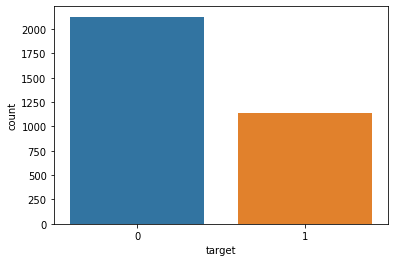

In [51]:
# Plot info on the submissions
print(submission.describe())
ax = sns.countplot(x='target', data=submission)

## 7. Competition results

When submited to the Kaggle competion, the results obtained in this notebook scored a 0.79681, on a 46% percentile.